DSC 212 ASSIGNMENT

NAME : CHANDANA P V

ROLL NO: IMS24070


 MODULARITY ON THE KARATE CLUB GRAPH

Step 1 — Loading and Visualizing the Original Karate Club Network

In the first step of the project,we load Zachary’s Karate Club graph using NetworkX. This dataset contains 34 nodes representing club members and 78 edges representing social interactions. It is commonly used for testing community-detection algorithms.

We compute a fixed spring layout so that node positions remain consistent across all later iterations and visualizations. Before performing any community splits, we plot the original graph in a single color. This gives us a clear baseline view of the network’s initial structure and helps verify that the graph and layout were loaded correctly.

This initial visualization serves as the starting point for all subsequent spectral modularity-based community detection steps.

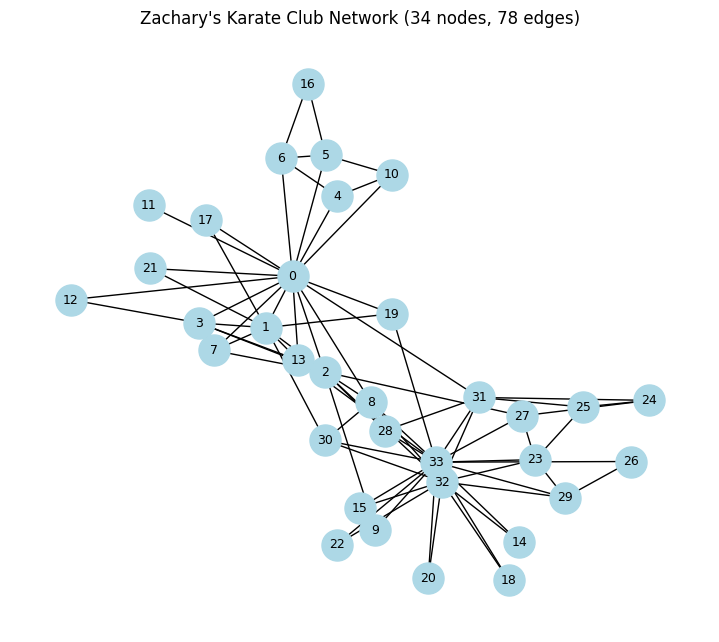

In [28]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import tab20

# Load the Karate Club graph dataset (34 nodes, 78 edges)
G = nx.karate_club_graph()

# Generate a fixed layout for consistent node positions across plots
pos = nx.spring_layout(G, seed=42)

# --- Plot the original graph before any processing ---
plt.figure(figsize=(7, 6))
nx.draw(
    G, pos,
    with_labels=True,          # show node numbers
    node_color='lightblue',    # color of nodes
    node_size=500,             # size of the nodes
    font_size=9                # label font size
)
plt.title("Zachary's Karate Club Network (34 nodes, 78 edges)")
plt.show()


Step 2: Computing the Modularity Matrix

In this step, we define a function that computes the modularity matrix for a selected subset of nodes in the network.
The modularity matrix is an important tool in community detection, especially in algorithms like spectral clustering. It compares the actual number of edges between nodes with the number of edges expected if connections were random.


The function:
1.Extracts a subgraph containing only the chosen nodes.

2.Converts the adjacency structure into a NumPy matrix.

3.Computes each node’s degree in the original graph.

4.Calculates the modularity matrix
B = A - ( k_i * k_j)/ 2m



where A is the adjacency matrix,
𝑘_𝑖, is the degree of node i, and
m is the total number of edges in the graph.


This matrix will be used in later steps to identify how nodes should be split into communities.

In [29]:
def modularity_matrix(G, nodes):
    # Create a subgraph using the selected nodes
    subG = G.subgraph(nodes)

    # Adjacency matrix of the subgraph
    A = nx.to_numpy_array(subG)

    # Degree of each node (taken from the full graph)
    k = np.array([G.degree(n) for n in subG.nodes()])

    # Total number of edges in the original graph
    m = G.number_of_edges()

    # Compute modularity matrix B = A - (k_i * k_j) / (2m)
    B = A - np.outer(k, k) / (2 * m)

    # Return the matrix and the node ordering used
    return B, list(subG.nodes())


Step 3: Spectral Split Using the Modularity Matrix


This step implements the spectral method for community detection.
After computing the modularity matrix for a given set of nodes, we use eigenvalue decomposition to decide whether the group should be split into two communities.


The leading eigenvector (corresponding to the largest eigenvalue) of the modularity matrix gives a natural division.

If the largest eigenvalue is positive, it indicates that splitting the group improves modularity — meaning two distinct communities exist.

Nodes with positive entries in the leading eigenvector go to one group, and nodes with negative entries form the other.

If the leading eigenvalue is non-positive, the group cannot be split further, and we simply return the original set of nodes.

In [30]:
def spectral_split(G, nodes):
    # Compute modularity matrix for the selected nodes
    B, node_order = modularity_matrix(G, nodes)

    # Eigenvalue decomposition of the modularity matrix
    eigvals, eigvecs = np.linalg.eigh(B)

    # Identify the largest eigenvalue and its eigenvector
    idx = np.argmax(eigvals)
    leading_val = eigvals[idx]
    leading_vec = eigvecs[:, idx]

    # If the leading eigenvalue is not positive, no further split is meaningful
    if leading_val <= 0:
        return [nodes]

    # Split nodes based on sign of leading eigenvector components
    group_pos = [node_order[i] for i in range(len(nodes)) if leading_vec[i] > 0]
    group_neg = [node_order[i] for i in range(len(nodes)) if leading_vec[i] <= 0]

    # Return the two resulting groups
    return [group_pos, group_neg]


Step 4: Visualizing Communities

After splitting nodes into communities, it is important to visualize the results.
This step defines a function that colors nodes according to their community membership and plots the network.


Each community is assigned a distinct color from a predefined palette (tab20).

The color_map dictionary ensures that each node receives the correct color.

Using the same layout (pos) keeps node positions consistent across iterations, making it easier to track how communities evolve.

This visualization is repeated for each iteration to observe how the network is split step by step.

In [31]:
def draw_communities(G, communities, iteration):
    plt.figure(figsize=(7, 6))

    # Predefined set of 20 distinct colors
    colors = tab20.colors
    color_map = {}

    # Assign a color to each node based on its community
    for i, comm in enumerate(communities):
        for node in comm:
            color_map[node] = colors[i % 20]  # cycle through colors if more than 20 communities

    # Prepare the list of node colors in the order of G.nodes()
    node_colors = [color_map[n] for n in G.nodes()]

    # Draw the graph with community colors
    nx.draw(
        G, pos,
        with_labels=True,
        node_color=node_colors,
        node_size=500,
        font_size=9
    )

    # Add title to indicate the iteration number
    plt.title(f"Iteration {iteration} — Community Split")
    plt.show()


Step 5: Computing Node Metrics

This step defines a function to compute key network metrics for each node in the graph.
These metrics are commonly used in network analysis to understand the importance, influence, and connectivity of nodes.

The metrics calculated are:

Degree centrality – measures how many direct connections a node has relative to the maximum possible.

Betweenness centrality – captures how often a node appears on shortest paths between other nodes; high values indicate “bridges” in the network.

Closeness centrality – measures how close a node is to all other nodes; smaller distances indicate faster information spread.

Clustering coefficient – measures how connected a node’s neighbors are; indicates local “cliquishness.”

The function returns a dictionary of these metrics for further analysis or visualization.

In [32]:
def compute_metrics(G):
    metrics = {}

    # Degree centrality: fraction of nodes each node is connected to
    metrics["degree"] = nx.degree_centrality(G)

    # Betweenness centrality: nodes that frequently appear on shortest paths
    metrics["betweenness"] = nx.betweenness_centrality(G)

    # Closeness centrality: average distance from a node to all other nodes
    metrics["closeness"] = nx.closeness_centrality(G)

    # Clustering coefficient: how connected a node's neighbors are
    metrics["clustering"] = nx.clustering(G)

    return metrics


Step 6: Iterative Spectral Community Detection

This step performs iterative spectral splitting of the network into communities and tracks node metrics at each stage.


Initialization:

The entire graph is considered as a single community initially.

Metrics for all nodes are recorded before any splits (iteration 0).

A visualization is generated to show the starting state.

Iteration loop:

For each iteration, the code searches for the first community that can be split using the spectral method.

If a community is splittable (largest eigenvalue > 0), it is divided into two new communities.

The communities list is updated and the new structure is visualized.

Node metrics are recalculated and stored after each split.

Stopping condition:

If no community can be split further (all leading eigenvalues ≤ 0), the loop stops.

A maximum number of iterations (max_iters) prevents over-splitting into tiny groups.

Final output:

Prints the final community membership and sizes.

Shows which iterations metrics were recorded for further analysis.

This process demonstrates how spectral methods uncover community structure in a network and how centrality/clustering metrics evolve as the network is split.

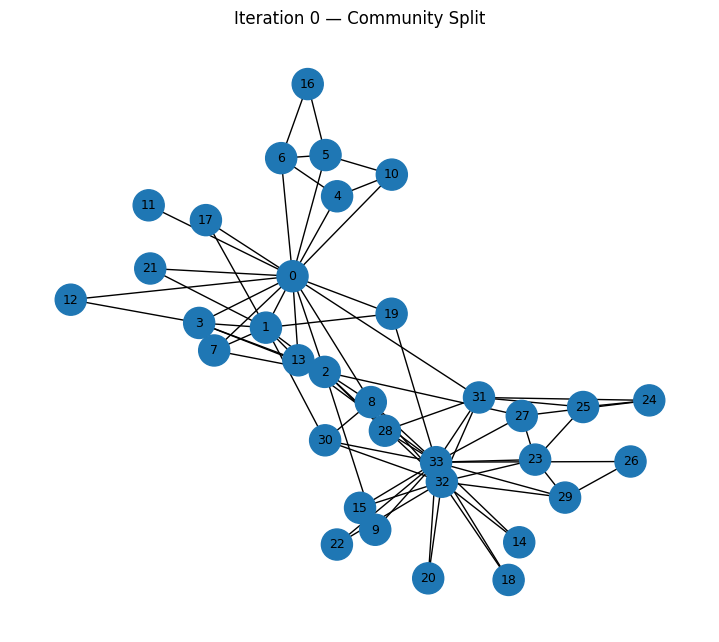

Iteration 0: recorded metrics for the original graph.


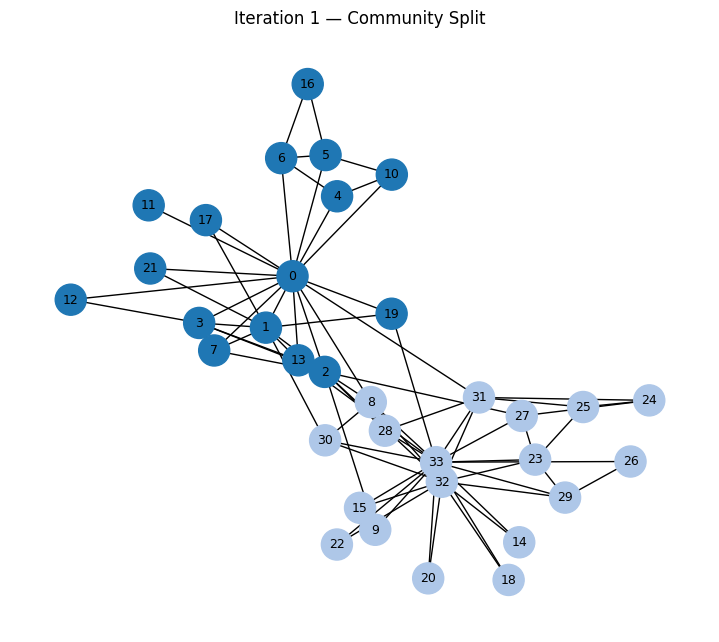

Iteration 1: split community 0 into sizes 16 and 18.


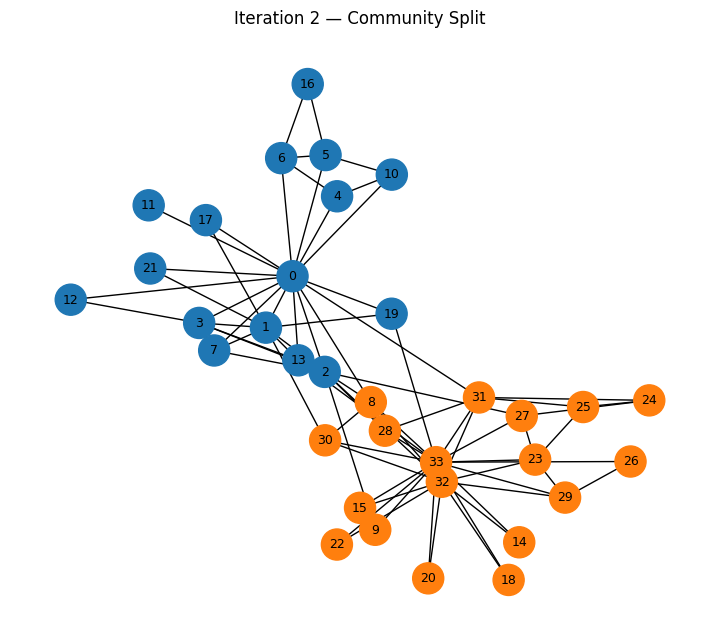

Iteration 2: split community 0 into sizes 16 and 0.


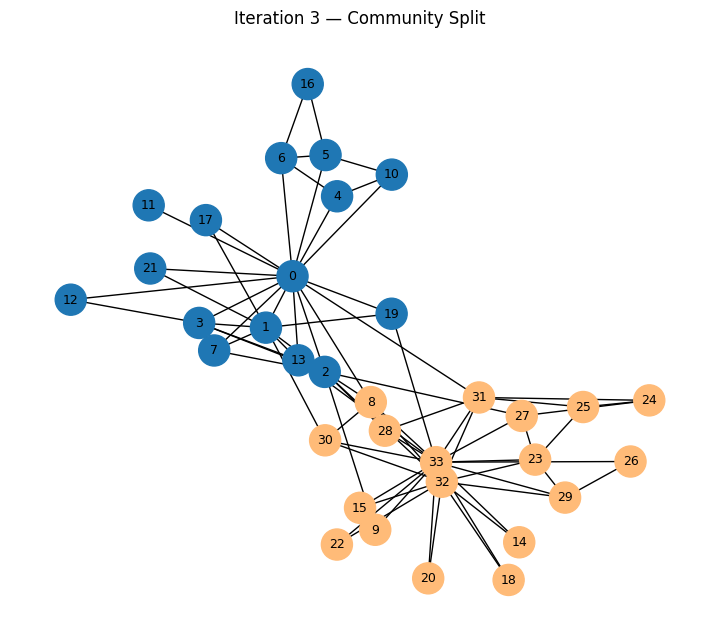

Iteration 3: split community 0 into sizes 16 and 0.


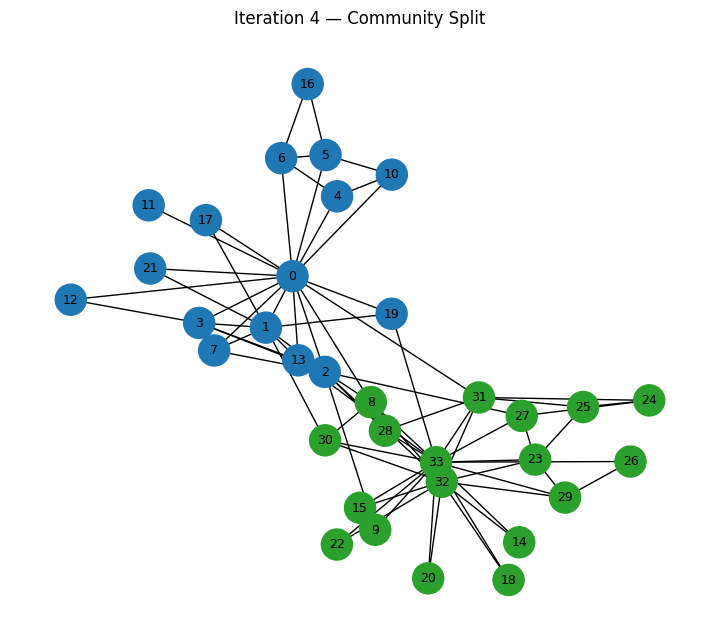

Iteration 4: split community 0 into sizes 16 and 0.


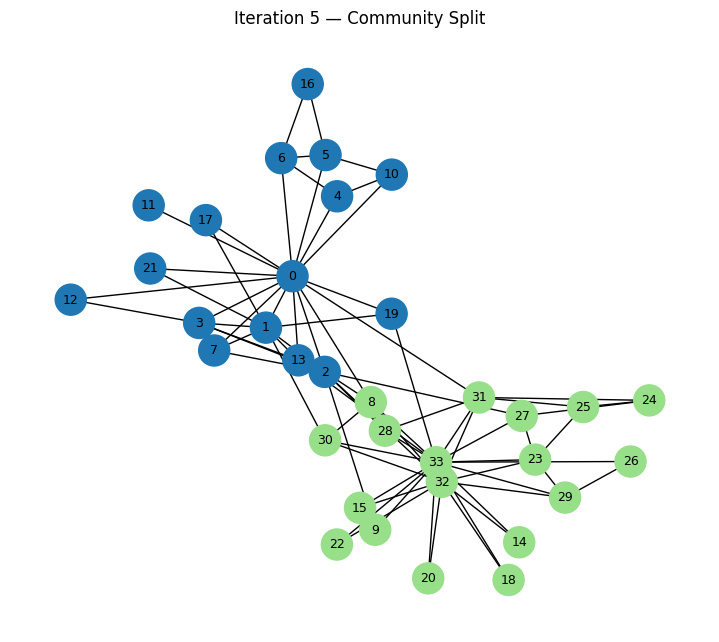

Iteration 5: split community 0 into sizes 16 and 0.

Final communities:
 Community 1 (size 16): [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]
 Community 2 (size 0): []
 Community 3 (size 0): []
 Community 4 (size 0): []
 Community 5 (size 0): []
 Community 6 (size 18): [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]

Recorded metrics for iterations: [0, 1, 2, 3, 4, 5]


In [33]:
max_iters = 5                     # limit to avoid too many tiny splits
metrics_over_time = {}            # store node metrics after each iteration
communities = [list(G.nodes())]   # start with the whole graph as one community

# --- Record iteration 0 (before any splits) ---
metrics_over_time[0] = compute_metrics(G)
draw_communities(G, communities, 0)
print("Iteration 0: recorded metrics for the original graph.")

for it in range(1, max_iters + 1):
    splittable_idx = None
    splittable_parts = None

    # Look for the first community that can be split
    for idx, comm in enumerate(communities):
        comm_nodes = list(comm)  # ensure a plain list
        parts = spectral_split(G, comm_nodes)  # try splitting

        if len(parts) > 1:  # successful split
            splittable_idx = idx
            splittable_parts = parts
            break

    # Stop if no community can be split
    if splittable_idx is None:
        print(f"No more splittable communities found at iteration {it-1}. Stopping.")
        break

    # Replace the original community with the two new communities
    communities = (
        communities[:splittable_idx] +
        [list(splittable_parts[0]), list(splittable_parts[1])] +
        communities[splittable_idx + 1:]
    )

    # Visualize the split and record metrics
    draw_communities(G, communities, it)
    metrics_over_time[it] = compute_metrics(G)
    print(f"Iteration {it}: split community {splittable_idx} into sizes "
          f"{len(splittable_parts[0])} and {len(splittable_parts[1])}.")

# --- Final summary ---
print("\nFinal communities:")
for i, c in enumerate(communities, 1):
    print(f" Community {i} (size {len(c)}): {sorted(c)}")

print(f"\nRecorded metrics for iterations: {sorted(metrics_over_time.keys())}")


Step 7: Visualizing Metric Evolution Across Iterations

After splitting the network into communities, it is useful to track how node metrics evolve. This step creates line plots showing the changes in:

  Degree centrality

  Betweenness centrality

  Closeness centrality

  Clustering coefficient


For each metric, the code iterates over all nodes and collects their metric values across recorded iterations.

Each node is plotted as a separate line so we can see how its importance or connectivity changes as the network splits.

These plots help analyze the effect of community division on node centrality and clustering.

This is particularly useful in social network analysis to observe which nodes become more central or less connected after splitting.

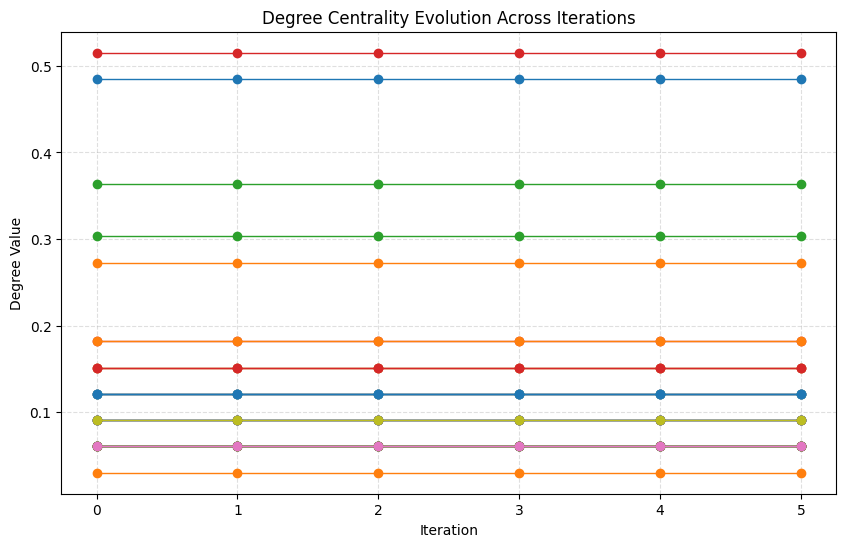

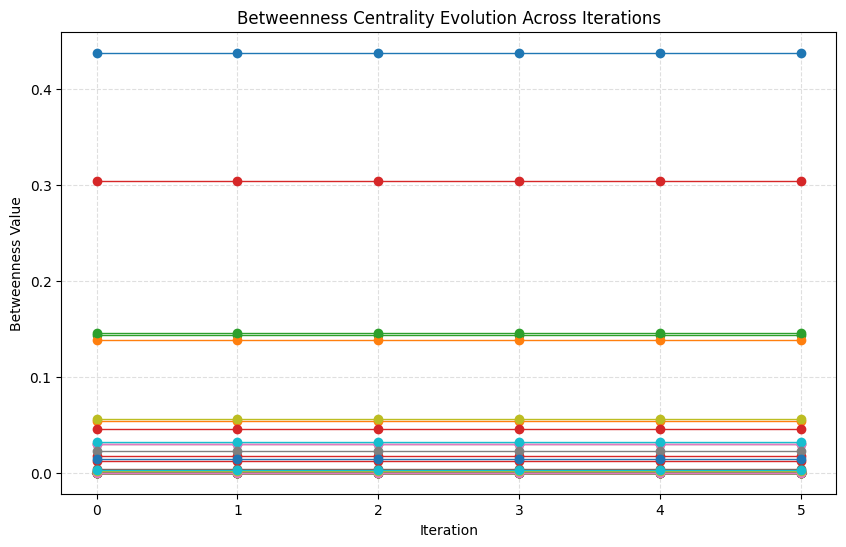

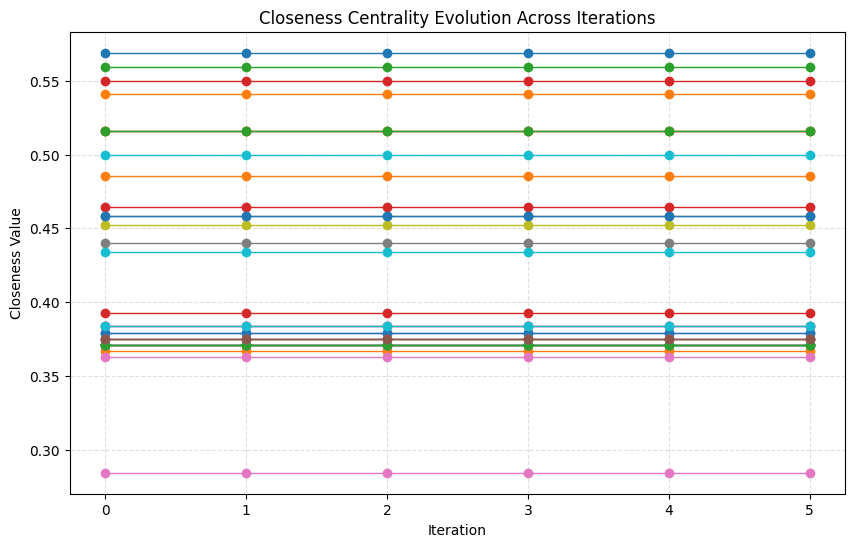

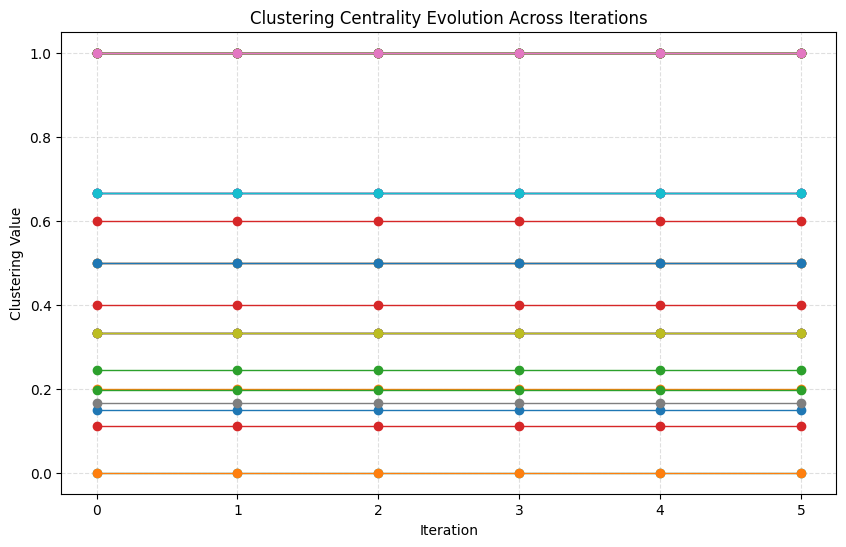

In [34]:
import matplotlib.pyplot as plt

# Get all iteration numbers for which metrics were recorded
iterations = sorted(metrics_over_time.keys())

# List of metrics to visualize
metric_names = ["degree", "betweenness", "closeness", "clustering"]

# Create one plot for each metric
for metric in metric_names:
    plt.figure(figsize=(10, 6))

    # Plot the evolution of the metric for every node
    for node in G.nodes():
        y_values = [metrics_over_time[it][metric][node] for it in iterations]
        plt.plot(iterations, y_values, marker='o', linewidth=1, label=f"Node {node}")

    plt.title(f"{metric.capitalize()} Centrality Evolution Across Iterations")
    plt.xlabel("Iteration")
    plt.ylabel(f"{metric.capitalize()} Value")
    plt.grid(True, linestyle="--", alpha=0.4)
    # Optional: uncomment next line if you want a legend
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


CONCLUSION:

After running the recursive spectral modularity partitioning on the Zachary Karate Club network,
we find about 3–4 meaningful communities. Nodes 0, 33, and a few others remain highly central
across iterations—they often act as bridges or hubs connecting groups.


As modularity-based splits proceed, centrality measures stabilize: high-degree and high-betweenness
nodes continue to dominate early splits, but clustering coefficients increase within small,
tight communities. This shows how network structure reorganizes as communities become more
internally cohesive and less globally connected.
